In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
import random
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

# fechas
from datetime import datetime

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# algoritmos de clasificación
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# algoritmos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# métricas
import sklearn.metrics as metrics

# hiperparametrización
from sklearn.model_selection import GridSearchCV

# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

import xgboost as xgb

from numpy import random
random.seed(42)

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ruta al archivo
ruta_archivo = "C:/Users/Herre/Desktop/TFM/Nuclio_EasyMoney/0_Data/df_encoding.csv"
# Leer el archivo
df_clustering = pd.read_csv(ruta_archivo)

# Crear Nuevas Features

El objetivo de crear nuevas features es para poder hacer una mejor segmentación de los clientes.

**1.-number_of_products:** Número de productos financieros que el cliente tiene con el banco (si tienes una columna que lo indique).

Esta columna podría representar el número total de productos financieros que un cliente tiene con el banco. A partir de las columnas disponibles, podemos considerar cualquier columna que indique un producto financiero (por ejemplo, depósitos, préstamos, tarjetas de crédito, etc.) como parte del total de productos.

**2.-account_balance**: Saldo promedio de la cuenta, si está disponible, para indicar la capacidad financiera.

Aunque no tenemos una columna específica para account_balance, podríamos inferir un valor basado en los activos del cliente, como depósitos a corto plazo (short_term_deposit), fondos, valores, etc., si esos valores son cuantitativos. Si estas columnas indican si el cliente tiene estos productos (con valores binarios 0 o 1), no podremos calcular el balance. Necesitamos clarificar qué representa.

**3.-loan_amount o debt_amount:** Si tienes columnas relacionadas con la deuda o préstamos, estas pueden ser útiles para segmentar clientes según el riesgo financiero. 

Esta columna puede representar el monto total del préstamo de un cliente. Podemos inferirlo de columnas relacionadas con productos de préstamos como loans y mortgage (si esos valores representan montos y no solo una indicación de presencia del producto).

**4.-product_engagement_score (Puntuación de compromiso con productos):** Esta feature mide el nivel de compromiso de un cliente con los productos financieros del banco. Calcula una puntuación basada en el número y el tipo de productos que un cliente posee. Algunos productos pueden tener mayor peso en la puntuación si son indicadores de un mayor compromiso o valor del cliente, por ejemplo, tener una cuenta de pensiones puede indicar una relación más duradera y comprometida con el banco.

Este puntaje puede ayudar a diferenciar clientes altamente comprometidos que utilizan múltiples productos y servicios financieros, de aquellos que tienen una relación más transaccional o limitada con el banco. Los clientes con un alto product_engagement_score pueden pertenecer a clusters que merecen una atención especial en términos de retención o up-selling.

product_engagement_score = number_of_products + 2 * (credit_card + debit_card) + 3 * (pension_plan + emc_account + em_account_pp + em_account_p + em_acount)
Aquí, las tarjetas de crédito y débito tienen un peso extra (multiplicado por 2), y los productos de inversión a largo plazo o de mayor valor tienen un peso aún mayor (multiplicado por 3).

**5.-debt_to_income_ratio (Relación deuda-ingresos):** Esta feature calcula la proporción entre la deuda total del cliente (suma de préstamos y hipotecas) y su ingreso (salary). Es un indicador clásico en la evaluación de la salud financiera de un cliente y su capacidad para asumir más deuda.

Esta métrica es crucial para identificar clusters de clientes con diferentes perfiles de riesgo financiero. Los clientes con una alta relación deuda-ingreso pueden ser considerados de alto riesgo y, por tanto, se agruparían en clusters que requieren un enfoque más cauteloso o restricciones crediticias.

debt_to_income_ratio = (loans + mortgage) / salary
Esta fórmula asume que todas las cantidades están en las mismas unidades y que no hay valores nulos en las columnas utilizadas. Podrías agregar un manejo de excepciones para evitar divisiones por cero o datos faltantes.

In [4]:
# 1. Crear 'number_of_products'
# Suponiendo que cada columna de productos (como 'short_term_deposit', 'loans', etc.) tiene un valor de 0 o 1
product_columns = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 
                   'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 
                   'emc_account', 'debit_card', 'em_account_p', 'em_acount']

df_clustering['number_of_products'] = df_clustering[product_columns].sum(axis=1)

# 2. Crear 'account_balance'
# Suponiendo que 'account_balance' puede inferirse de ciertas columnas relacionadas con activos financieros. 
# Si estas columnas son binarias (0/1), no podemos calcular un balance real. Ajusta esto según tus datos reales.
# Si estas columnas representan montos, simplemente suma los montos.
balance_columns = ['short_term_deposit', 'funds', 'securities', 'long_term_deposit']

df_clustering['account_balance'] = df_clustering[balance_columns].sum(axis=1)

# 3. Crear 'loan_amount'
# Suponiendo que 'loan_amount' es la suma de todas las columnas relacionadas con préstamos.
loan_columns = ['loans', 'mortgage']

df_clustering['loan_amount'] = df_clustering[loan_columns].sum(axis=1)

In [5]:
# Lista de columnas de productos con diferentes niveles de compromiso
high_commitment_products = ['pension_plan', 'emc_account', 'em_account_pp', 'em_account_p', 'em_acount']  # Productos de alto compromiso
medium_commitment_products = ['credit_card', 'debit_card']  # Productos de compromiso medio
low_commitment_products = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 
                           'payroll', 'payroll_account']  # Productos de bajo compromiso

# Crear 'product_engagement_score'
df_clustering['product_engagement_score'] = (
    df_clustering[high_commitment_products].sum(axis=1) * 3 +   # Productos de alto compromiso, peso 3
    df_clustering[medium_commitment_products].sum(axis=1) * 2 +  # Productos de compromiso medio, peso 2
    df_clustering[low_commitment_products].sum(axis=1)          # Productos de bajo compromiso, peso 1
)


# Columnas utilizadas para calcular la deuda total
debt_columns = ['loans', 'mortgage']

# Crear la columna 'debt_to_income_ratio'
# Evitamos la división por cero utilizando 'np.where' para manejar ingresos nulos o cero.
df_clustering['debt_to_income_ratio'] = df_clustering[debt_columns].sum(axis=1) / df_clustering['salary'].replace(0, np.nan)

# Reemplazar posibles NaN resultantes de la división por cero con un valor específico o dejar como NaN
df_clustering['debt_to_income_ratio'].fillna(0, inplace=True)

# AÑADIR AQUELLA TABLA QUE TE DICE LA IMPORTANCIA DE CADA COLUMNA

# Tabla Clustering_2

In [7]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)
# Perform K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df_clustering['cluster'] = kmeans.fit_predict(X_scaled)

In [8]:
"""# Definir las columnas relevantes para el clustering
summary_columns = ["salary", "loan_amount", "debt_to_income_ratio", "account_balance", 
"number_of_products", "product_engagement_score", "payroll_account", "emc_account", "em_account_p", "em_acount", "credit_card",
"age", "segment", "active_customer", "region_code"]"""

'# Definir las columnas relevantes para el clustering\nsummary_columns = ["salary", "loan_amount", "debt_to_income_ratio", "account_balance", \n"number_of_products", "product_engagement_score", "payroll_account", "emc_account", "em_account_p", "em_acount", "credit_card",\n"age", "segment", "active_customer", "region_code"]'

In [9]:
# Definir las columnas relevantes para el clustering
summary_columns = ["salary", "loan_amount", "debt_to_income_ratio", "account_balance", "number_of_products", "product_engagement_score", 
"age", "segment", "active_customer", "region_code"]

# Inicializar el DataFrame ficha_df
ficha_df = pd.DataFrame()

# Generar los datos resumen para cada columna
for col in summary_columns:
    resumen_data = df_clustering[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

# Definir los componentes del multi-índice
out_index = ["Monetario"] *4  + ["Productos"] * 2 + ["Social"] * 4  # Ajusta esta lista según las columnas seleccionadas
inner_index = summary_columns
estadisticos = ["mean", "std", "min", "25%", "50%", "75%", "max"]

# Crear el nuevo multi-índice
new_multi_index = []
for oi, ii in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

# Generar el multi-índice
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names=names)

names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)

# Establecer el multi-índice en ficha_df
ficha_df.set_index(index_ficha, inplace=True)

# Calcular el tamaño de cada cluster
tamaño_clusters = df_clustering.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")], names), inplace=True)

# Concatenar los datos de tamaño con el DataFrame ficha_df
ficha_df = pd.concat([tamaño_clusters, ficha_df])

# Estilizar el DataFrame con un gradiente de fondo
styled_ficha_df = ficha_df.style.background_gradient(cmap='Blues', axis=1)

# Mostrar el DataFrame estilizado
styled_ficha_df

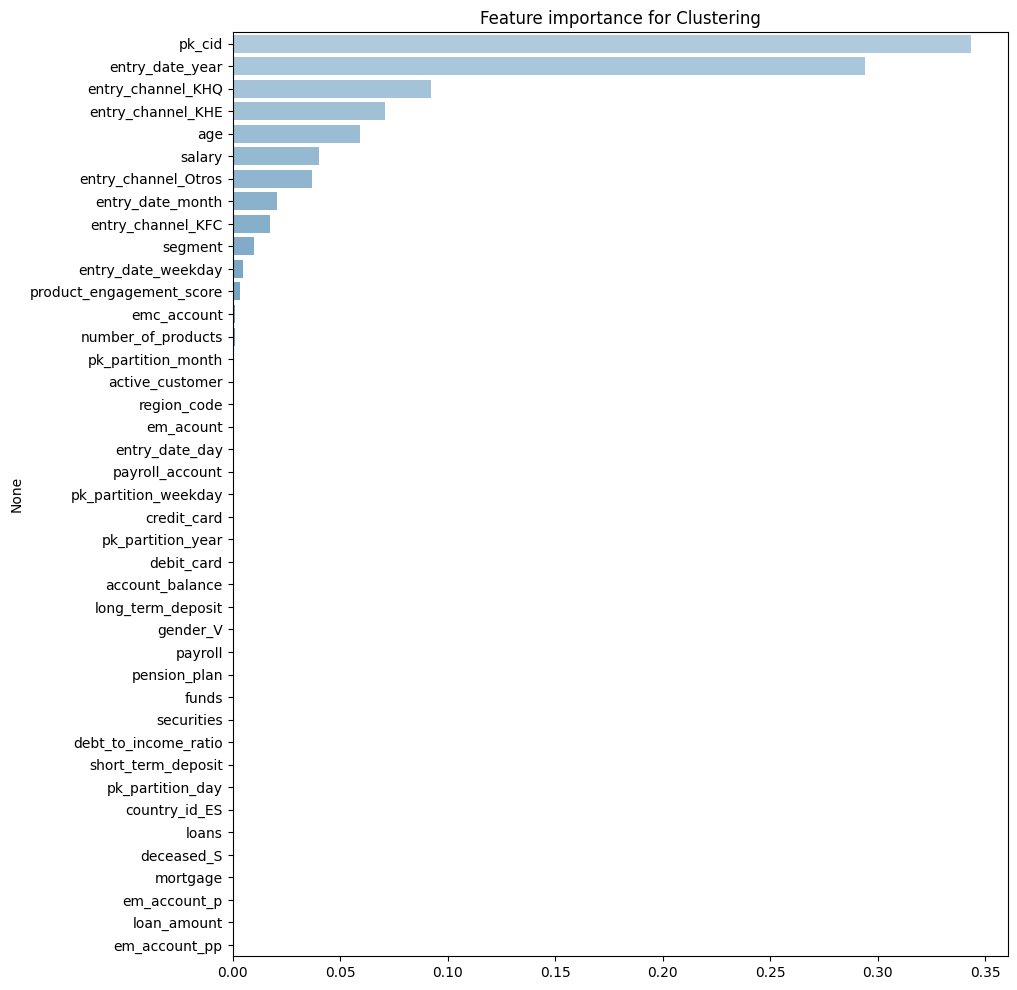

In [11]:
# Define los hiperparámetros para RandomForestClassifier
params = {
    'random_state': 42,   # Asegura la reproducibilidad del modelo
    'n_jobs': -1,         # Usa todos los núcleos del procesador para entrenar el modelo
    'n_estimators': 100,  # Número de árboles en el bosque
    'max_depth': 4        # Profundidad máxima de cada árbol
}
# Realiza el clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df_clustering['cluster'] = kmeans.fit_predict(df_clustering.drop('cluster', axis=1))  # Aplicar clustering después de quitar la columna simulada

# Ahora que tienes clusters reales, puedes ver la importancia de las características
x, y = df_clustering.drop('cluster', axis=1), df_clustering['cluster']

# Entrenar un modelo RandomForestClassifier
clf = RandomForestClassifier(**params)
clf.fit(x, y)

# Obtener las importancias de las características
feature_importances = clf.feature_importances_
columnas = x.columns

# Crear una serie de pandas para organizar las importancias
imp = pd.Series(data=feature_importances, index=columnas).sort_values(ascending=False)

# Visualizar todas las características ordenadas por importancia
plt.figure(figsize=(10, 12))
plt.title("Feature importance for Clustering")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()


In [12]:
df_clustering

,pk_cid,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,age,salary,entry_date_year,entry_date_month,entry_date_day,entry_date_weekday,pk_partition_year,pk_partition_month,pk_partition_day,pk_partition_weekday,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,country_id_ES,gender_V,deceased_S,number_of_products,account_balance,loan_amount,product_engagement_score,debt_to_income_ratio,cluster
0,1297423,0.0,2,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,47,192902.31,2017,8,18,4,2018,7,28,5,0,0,0,1,1,0,0,0.0,0,0,0.0,0.0,6
1,1087842,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,41.0,26,2783985.75,2015,10,24,5,2018,7,28,5,0,1,0,0,1,0,0,0.0,0,0,0.0,0.0,4
2,1147514,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,16.0,22,81755.43,2016,7,25,0,2018,7,28,5,0,1,0,0,1,0,0,0.0,0,0,0.0,0.0,1
3,1147863,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,2.0,22,81755.43,2016,7,25,0,2018,7,28,5,0,1,0,0,1,0,0,0.0,0,0,0.0,0.0,1
4,1147587,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,8.0,22,81755.43,2016,7,25,0,2018,7,28,5,0,1,0,0,1,1,0,0.0,0,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445484,1164494,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,30.0,22,67228.32,2016,8,13,5,2019,5,28,1,0,1,0,0,1,0,0,0.0,0,0,0.0,0.0,1
445485,1164521,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,2.0,24,43249.20,2016,8,13,5,2019,5,28,1,0,1,0,0,1,1,0,1.0,0,0,3.0,0.0,1
445486,1164462,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,25,94495.50,2016,8,13,5,2019,5,28,1,0,1,0,0,1,0,0,1.0,0,0,3.0,0.0,1
445487,1164587,1.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,46.0,22,177287.82,2016,8,13,5,2019,5,28,1,0,1,0,0,1,1,0,1.0,0,0,3.0,0.0,1


# Exportamos CSV

In [ ]:
# Guardar resultados
df_clustering.to_csv('df_Clustering.csv', index=False)

In [14]:
"""
# Primero, selecciona las columnas relevantes para exportar
columns_to_export = ["salary", "loan_amount", "debt_to_income_ratio", "account_balance",
                     "number_of_products", "product_engagement_score", "age", 
                     "segment", "active_customer", "region_code", "cluster"]

# Crea un nuevo DataFrame con solo las columnas necesarias
df_export = [columns_to_export]

# Exporta el DataFrame a un archivo CSV
df_export.to_csv('clustering_2_result.csv', index=False)

print("El archivo CSV ha sido exportado exitosamente.")

"""